In [1]:
"hi[]"

'hi[]'

In [2]:
from zipfile import ZipFile
from pathlib import Path
import msgpack

In [3]:
ID = "2021-04-16"
N = [30, 90, 180, 300]
N_ANS = 10_000_000

In [4]:
from collections import defaultdict

def _get_zip(zf, filter=None):
    data = defaultdict(list)
    for f in zf.filelist:
        assert ".msgpack" in f.filename
        ir = zf.read(f)
        raw = msgpack.loads(ir)
        assert set(raw.keys()) == {"embedding", "history", "perf", "params", "meta"}
        _ = raw.pop("history")
        assert "history" not in raw
        n = raw["params"]["n"]
        if filter is None or filter(raw):
            data[n].append(raw)
    return data

data = defaultdict(list)

filters = {
    "random-n=[90, 180, 300].zip": lambda raw: (
        raw["meta"]["sampling"] == "random" and raw["meta"]["n"] in [90, 180, 300]
    ),
    "n=30.zip": lambda raw: (
        raw["meta"]["n"] == 30
    ),
    "embeddings.zip": lambda raw: (raw["meta"]["sampling"] == "active"),
}
for fname in ["embeddings.zip", "n=30.zip", "random-n=[90, 180, 300].zip"]:
    with ZipFile(f"io/{ID}/{fname}") as zf:
        print(f"{len(zf.filelist)} embeddings")
        
        filter = lambda x: x["meta"]["sampling"] == "random"
        _data = _get_zip(zf, filter=filters[fname])
        for n, li in _data.items():
            data[n].extend(li)

print(sum(len(v) for v in data.values()))

147 embeddings
254 embeddings
690 embeddings
1042


In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import stats
X_tests = {n: stats.test_responses(n) for n in N}

In [7]:
import targets as targets_module
targets = {n: targets_module.get(n) for n in N}

In [8]:
import numpy as np
for n, n_data in data.items():
    for k, datum in enumerate(n_data):
        if k % 20 == 0:
            print(n, k)
        datum["embedding"] = np.asarray(datum["embedding"])
        
for n, n_X_tests in X_tests.items():
    for name, arr in n_X_tests.items():
        print(n, name)
        X_test = np.asarray(arr)
        print(len(X_test))
        idx = np.random.choice(len(arr), replace=False, size=min(len(arr), N_ANS))
        print(len(idx))
        X_tests[n][name] = X_test[idx]

90 0
90 20
90 40
90 60
90 80
90 100
90 120
90 140
90 160
90 180
90 200
90 220
90 240
90 260
90 280
180 0
180 20
180 40
180 60
180 80
180 100
180 120
180 140
180 160
180 180
180 200
180 220
180 240
180 260
300 0
300 20
300 40
300 60
300 80
300 100
300 120
300 140
300 160
300 180
300 200
300 220
30 0
30 20
30 40
30 60
30 80
30 100
30 120
30 140
30 160
30 180
30 200
30 220
30 240
30 ground_truth
24360
24360
30 simulation
4204
4204
30 human
4014
4014
90 ground_truth
704880
704880
90 simulation
4205
4205
180 ground_truth
5735160
5735160
180 simulation
9803
9803
300 ground_truth
26730600
10000000
300 simulation
9989
9989


In [9]:
{type(X_tests[30][k]) for k in X_tests[30]}

{numpy.ndarray}

In [10]:
%%time

from time import time
show = []
for n, n_data in data.items():
    print(f"### n = {n}")
    _time = time()
    for k, datum in enumerate(n_data):
        if k % 10 == 0 and n > 30:
            print(k, time() - _time)
            _time = time()
        elif k == 0 and n == 30:
            print("(skipping; too quick)")
        for test_name, test_set in X_tests.get(n, {}).items():
            items_closer_than_true_NN = stats.items_closer_than_true_NN(datum["embedding"], targets[n])
            s = {
                "accuracy": stats.accuracy(datum["embedding"], test_set),
                "dataset": test_name,
                "noise_model": datum["params"]["noise_model"],
                "avg_number_closer_than_true_NN": np.mean(items_closer_than_true_NN),
                **datum["meta"],
                **stats.nn_accs(datum["embedding"], targets[n]),
            }
            show.append(s)

### n = 90
0 2.7894973754882812e-05
10 2.7284398078918457
20 2.570358991622925
30 2.645782947540283
40 2.4356210231781006
50 2.478364944458008
60 2.511777639389038
70 2.638312339782715
80 2.3986477851867676
90 2.127084970474243
100 2.0599770545959473
110 2.058011054992676
120 2.1893680095672607
130 2.4280879497528076
140 2.2090580463409424
150 2.1587979793548584
160 2.0582211017608643
170 1.9853172302246094
180 2.0984408855438232
190 2.227597236633301
200 2.1089251041412354
210 2.1518659591674805
220 2.1878089904785156
230 2.2364470958709717
240 2.164659261703491
250 2.710564136505127
260 2.9073288440704346
270 2.4201037883758545
280 2.1237571239471436
### n = 180
0 5.9604644775390625e-06
10 25.886677980422974
20 20.481592178344727
30 22.36246681213379
40 21.166380167007446
50 22.6145920753479
60 22.133745908737183
70 19.008893966674805
80 21.719448804855347
90 23.499924898147583
100 17.900214195251465
110 54.73601698875427
120 87.48921871185303
130 38.79567503929138
140 41.21740174293

In [11]:
import pandas as pd
df = pd.DataFrame(show)

In [12]:
df.columns

Index(['accuracy', 'dataset', 'noise_model', 'avg_number_closer_than_true_NN',
       'n', 'd', 'n_train', 'n_test', 'seed', 'num_ans', 'sampling',
       'est__random_state', 'est__noise_model', 'est__ident',
       'est__module__mu', 'nn_acc_radius_0', 'nn_acc_radius_1',
       'nn_acc_radius_2', 'nn_acc_radius_3', 'nn_acc_radius_4',
       'nn_acc_radius_5', 'nn_acc_radius_6', 'nn_acc_radius_7',
       'nn_acc_radius_8', 'nn_acc_radius_9', 'nn_acc_radius_10',
       'nn_acc_radius_11', 'nn_acc_radius_12', 'nn_acc_radius_13',
       'nn_acc_radius_14', 'nn_acc_radius_15', 'nn_acc_radius_16',
       'nn_acc_radius_17', 'nn_acc_radius_18', 'nn_acc_radius_19',
       'nn_acc_radius_20', 'nn_acc_radius_21', 'nn_acc_radius_22',
       'nn_acc_radius_23', 'nn_acc_radius_24', 'nn_acc_radius_25',
       'nn_acc_radius_26', 'nn_acc_radius_27', 'nn_acc_radius_28',
       'nn_acc_radius_29'],
      dtype='object')

In [13]:
__r = df[df.sampling == "random"].groupby("num_ans")["seed"].nunique()
__r

num_ans
30       10
90       10
180      10
300      10
330      10
         ..
42000     9
45000     9
48000     8
54000    10
60000     9
Name: seed, Length: 74, dtype: int64

In [14]:
__a = df[df.sampling == "active"].groupby("num_ans")["est__ident"].nunique()
assert set(__a.index[__a.index <= 5000]) == set(__r.index[__r.index <= 5000])
__a

num_ans
30       1
90       3
180      3
300      3
330      1
480      1
540      3
630      1
780      1
930      1
990      3
1080     3
1230     1
1380     1
1440     3
1500     1
1800     3
1890     3
1980     3
2100     1
2340     3
2400     1
2700     1
2790     3
2880     3
3000     1
3240     3
3300     3
3600     1
3690     3
3780     3
4140     3
4200     1
4500     3
4680     3
4800     3
5400     3
5580     3
6000     1
6300     3
6480     3
7200     3
7380     3
7500     1
7800     3
8100     3
8280     3
9000     3
9300     3
10800    3
12300    3
12600    3
13800    3
14400    3
15000    3
16200    3
18000    3
Name: est__ident, dtype: int64

In [15]:
df.dataset.unique()

array(['ground_truth', 'simulation', 'human'], dtype=object)

In [16]:
df.groupby(["n", "sampling"])["noise_model"].unique()

n    sampling
30   active                 [CKL]
     random                 [CKL]
90   active      [CKL, TSTE, SOE]
     random                 [CKL]
180  active      [CKL, TSTE, SOE]
     random                 [CKL]
300  active      [CKL, TSTE, SOE]
     random                 [CKL]
Name: noise_model, dtype: object

In [17]:
df.dataset.unique()

array(['ground_truth', 'simulation', 'human'], dtype=object)

167
1975
762


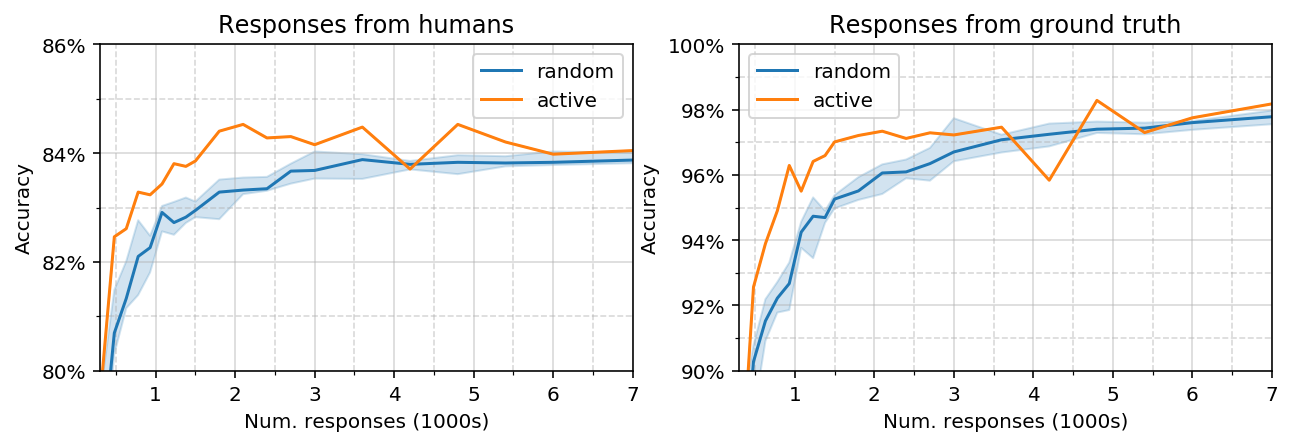

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

from plotting import lineplot

# idx = (df.n == 90) & (df.dataset == "ground_truth")
base = df.n == 30
active = (df.sampling == "active") & (df.noise_model == "CKL")
random = (df.sampling == "random") & (df.noise_model == "CKL")
print(active.sum())
print(random.sum())

idx = base & (random | active)
print(idx.sum())
df["error"] = 1 - df["accuracy"]

w = 3
fig, axs = plt.subplots(ncols=2, figsize=(3.5 * w, w))

base = dict(
    x="num_ans",
    y="accuracy",
    hue="sampling",
    hue_order=["random", "active"],
    ci=0.25,
    style="noise_model",
    estimator="median",
)

ax = lineplot(data=df[idx & (df.dataset == "human")], ax=axs[0], **base)
ax.set_title("Responses from humans")
_ = ax.set_ylim(0.8, 0.86)

ax = lineplot(data=df[idx & (df.dataset == "ground_truth")], ax=axs[1], **base)
ax.set_title("Responses from ground truth")
_ = ax.set_ylim(0.90, 1)

for ax in axs:
    _ = ax.grid(alpha=0.5, which="major")
    _ = ax.grid(alpha=0.5, which="minor", linestyle="--")
    _ = ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    _ = ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: np.round(x // 1000).astype(int)))
    _ = ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{np.round(100 * x).astype(int)}%"))
    _ = ax.yaxis.set_major_locator(plt.MultipleLocator(0.02))
    _ = ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
    _ = ax.set_xlabel("Num. responses (1000s)")
    _ = ax.set_ylabel("Accuracy")
    _ = ax.set_xlim(300, 7000)
    _ = ax.xaxis.set_minor_locator(plt.MultipleLocator(500))
#     _ = ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: float(x / 1000)))
# fig.savefig("figs/next.png", dpi=300, bbox_inches="tight", transparent=True)

167
1975
762


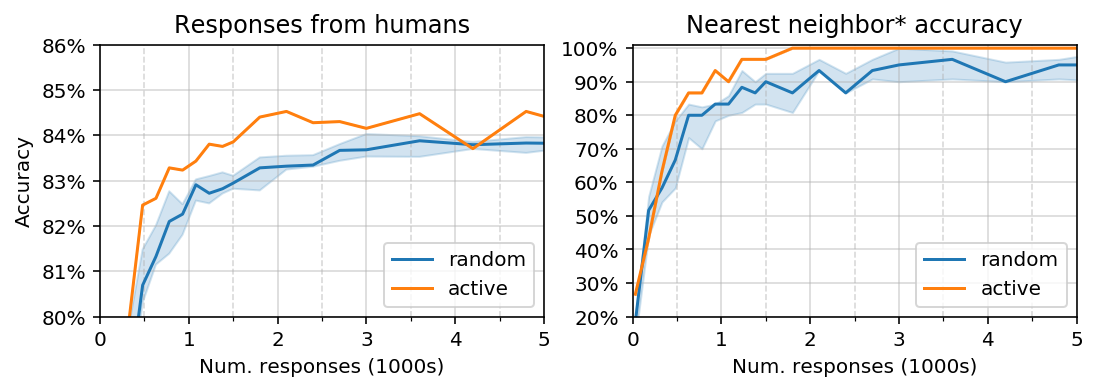

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

from plotting import lineplot

# idx = (df.n == 90) & (df.dataset == "ground_truth")
base = df.n == 30
active = (df.sampling == "active") & (df.noise_model == "CKL")
random = (df.sampling == "random") & (df.noise_model == "CKL")
print(active.sum())
print(random.sum())

idx = base & (random | active)
print(idx.sum())
df["error"] = 1 - df["accuracy"]

w = 2.5
fig, axs = plt.subplots(ncols=2, figsize=(3.5 * w, w))

base = dict(
    x="num_ans",
    hue="sampling",
    hue_order=["random", "active"],
    ci=0.25,
    style="noise_model",
    estimator="median",
)

ax = lineplot(data=df[idx & (df.dataset == "human")], ax=axs[0], y="accuracy", **base)
ax.set_title("Responses from humans")
_ = ax.set_ylim(0.8, 0.86)
_ = ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{np.round(100 * x).astype(int)}%"))
_ = ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
_ = ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
_ = ax.set_ylabel("Accuracy")

__d = df[idx & (df.dataset == "ground_truth")]
ax = lineplot(data=__d, y="nn_acc_radius_2", ax=axs[1], **base)
ax.set_ylim(0.2, 1.01)
ax.set_title("Nearest neighbor* accuracy")
_ = ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))
_ = ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{np.round(100 * x).astype(int)}%"))

for ax in axs:
    _ = ax.grid(alpha=0.5, which="major")
    _ = ax.grid(alpha=0.5, which="minor", linestyle="--")
    _ = ax.xaxis.set_major_locator(plt.MultipleLocator(1000))
    _ = ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: np.round(x // 1000).astype(int)))
    _ = ax.set_xlabel("Num. responses (1000s)")
    _ = ax.set_xlim(0, 5000)
    _ = ax.xaxis.set_minor_locator(plt.MultipleLocator(500))
#     _ = ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: float(x / 1000)))
fig.savefig("figs/next.png", dpi=300, bbox_inches="tight", transparent=True)

167
1975
762


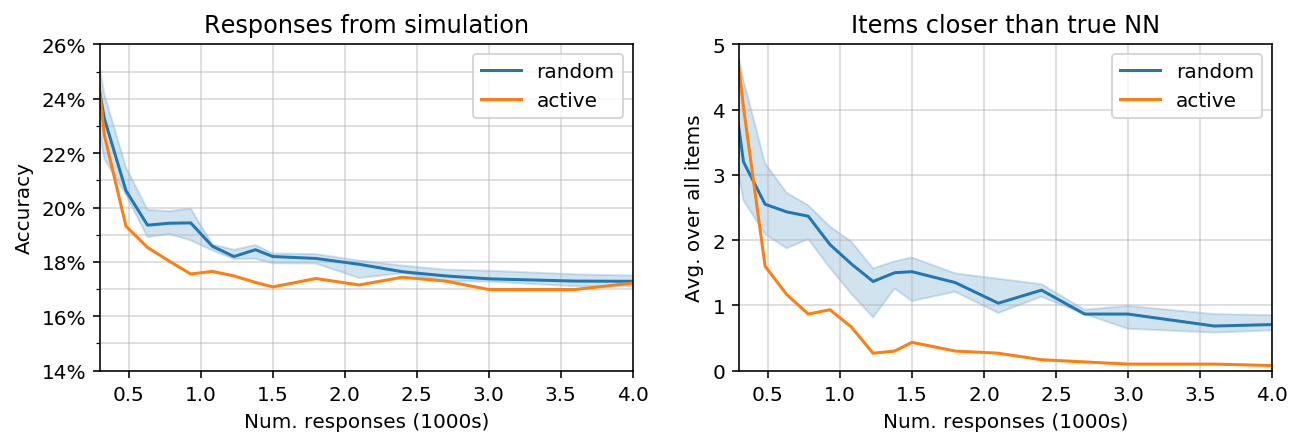

In [20]:
base = df.n == 30

anm = "CKL"
rnm = "CKL"
active = (df.sampling == "active") & (df.noise_model == anm)
random = (df.sampling == "random") & (df.noise_model == rnm)
print(active.sum())
print(random.sum())

idx = base & (random | active)
print(idx.sum())

w = 3
fig, axs = plt.subplots(ncols=2, figsize=(3.5 * w, w))

base = dict(
    x="num_ans",
    hue="sampling",
    hue_order=["random", "active"],
    ci=0.25,
    style="noise_model",
    estimator="median",
)

ax = lineplot(data=df[idx & (df.dataset == "simulation")], y="error", ax=axs[0], **base)
ax.set_ylim(0.14, 0.26)
ax.set_title("Responses from simulation")
_ = ax.yaxis.set_major_locator(plt.MultipleLocator(0.02))
_ = ax.yaxis.set_minor_locator(plt.MultipleLocator(0.01))
_ = ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(100 * x)}%"))
_ = ax.set_ylabel("Accuracy")

ax = lineplot(data=df[idx & (df.dataset == "ground_truth")], ax=axs[1],
              y="avg_number_closer_than_true_NN", **base)
ax.set_title("Responses from ground truth")
# _ = ax.set_ylim(0, None)
ax.set_ylim(0, 5)
ax.set_title("Items closer than true NN")
ax.set_ylabel("Avg. over all items")

for ax in axs:
    _ = ax.grid(alpha=0.5, which="both")
    _ = ax.set_xlim(300, 4000)
    _ = ax.xaxis.set_major_locator(plt.MultipleLocator(500))
    _ = ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{x/1000:0.1f}"))
    _ = ax.set_xlabel("Num. responses (1000s)")
    
# axs[0].set_xlim(300, 4000)
# axs[0].xaxis.set_major_locator(plt.MultipleLocator(500))
# axs[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: float(x / 1000)))
# fig.savefig("/Users/scott/Downloads/next-comparison.png", dpi=300, bbox_inches="tight", transparent=True)
fig.savefig("figs/sim.png", dpi=300, bbox_inches="tight", transparent=True)

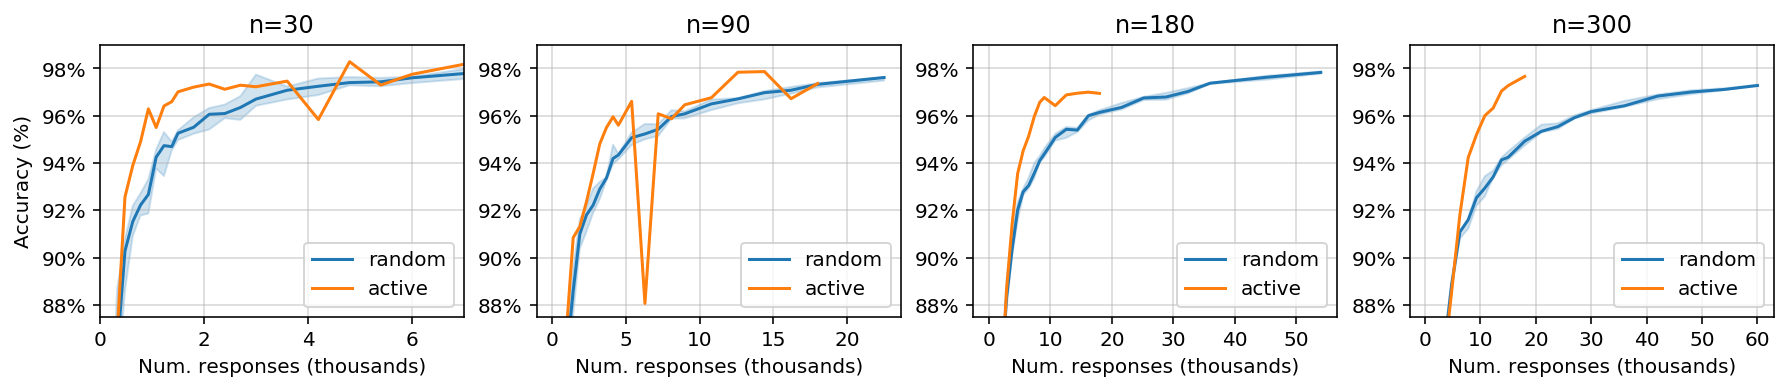

In [21]:
import altair as alt

active = (df.sampling == "active") & (df.noise_model == "CKL") 
random = (df.sampling == "random") & (df.noise_model == "CKL")
idx = (df.dataset == "ground_truth") & (active | random)

w = 2.5
fig, axs = plt.subplots(figsize=(4 * 1.5 * w, w), ncols=4)
kwargs = dict(
    x="num_ans", y="accuracy", hue="sampling", hue_order=["random", "active"], style=None,
)

ax = lineplot(data=df[(df.n == 30) & idx], **kwargs, ax=axs[0])
ax.set_xlim(0, 7000)

ax = lineplot(data=df[(df.n == 90) & idx], **kwargs, ax=axs[1])
ax.set_ylim(0, None)
# ax.set_xlim(0, 20_000)

ax = lineplot(data=df[(df.n == 180) & idx], **kwargs, ax=axs[2])
# ax.set_xlim(0, 20_000)

ax = lineplot(data=df[(df.n == 300) & idx], **kwargs, ax=axs[3])
ax.xaxis.set_major_locator(plt.MultipleLocator(10_000))
# ax.set_xlim(0, 20_000)

for ax in axs:
    ax.set_ylim(0.875, 0.99)
    ax.grid(alpha=0.5)
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(100 * x)}%"))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x / 1000)}"))
    _ = ax.set_xlabel("Num. responses (thousands)")

for ax, n in zip(axs, [30, 90, 180, 300]):
    ax.set_title(f"n={n}")

_ = axs[0].set_ylabel("Accuracy (%)")

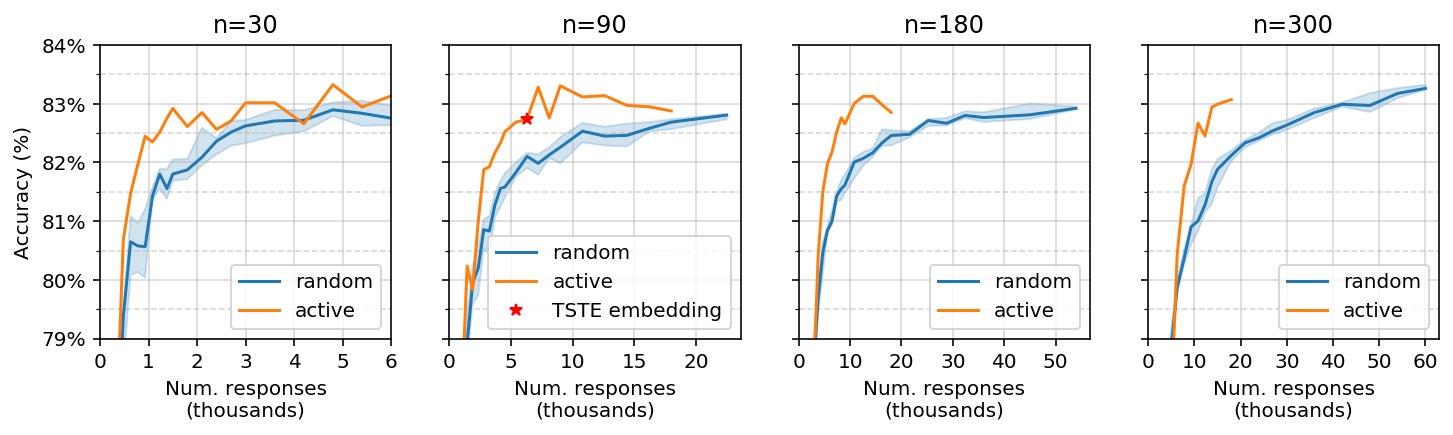

In [22]:
import altair as alt

active = (df.sampling == "active") & (df.noise_model == "CKL") 
random = (df.sampling == "random") & (df.noise_model == "CKL")
idx = (df.dataset == "simulation") & (active | random)

_idx = (df.n == 90) & (df.sampling == "active") & (df.noise_model != "SOE")
_idx &= (df.num_ans == 6300)
_idx &= df.dataset == "simulation"
ckl = _idx & (df.noise_model == "CKL")
tste = _idx & (df.noise_model == "TSTE")

show = df.copy()
show.loc[ckl, "accuracy"] = show.loc[tste, "accuracy"].item()

w = 3.0
fig, axs = plt.subplots(figsize=(4 * w, 0.9 * w), sharey=True, ncols=4, nrows=1)
axs = axs.flatten()
kwargs = dict(
    x="num_ans", y="accuracy", hue="sampling", hue_order=["random", "active"], style=None,
)

ax = lineplot(data=df[(df.n == 30) & idx], **kwargs, ax=axs[0])
ax.set_xlim(0, 6000)

ax = lineplot(data=show[(show.n == 90) & idx], **kwargs, ax=axs[1])
# ax.set_xlim(0, 20_000)

ax = lineplot(data=df[(df.n == 180) & idx], **kwargs, ax=axs[2])
# ax.set_xlim(0, 20_000)

ax = lineplot(data=df[(df.n == 300) & idx], **kwargs, ax=axs[3])
ax.xaxis.set_major_locator(plt.MultipleLocator(10_000))
# ax.set_xlim(0, 20_000)

for ax in axs:
    ax.set_ylim(0.79, 0.84)
    ax.grid(alpha=0.5)
    ax.grid(alpha=0.5, linestyle="--", which="minor")
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(100 * x)}%"))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))
    ax.yaxis.set_minor_locator(plt.MultipleLocator(0.005))
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x / 1000)}"))
    _ = ax.set_xlabel("Num. responses\n(thousands)")
    _ = ax.legend(loc="lower right")

for ax, n in zip(axs, [30, 90, 180, 300]):
    ax.set_title(f"n={n}")
    _ = ax.set_xlim(0, None)
    
axs[1].plot([6300], show.loc[ckl, "accuracy"], "r*", label="TSTE embedding")
axs[1].legend(loc="best")
axs[0].xaxis.set_major_locator(plt.MultipleLocator(1_000))
axs[1].xaxis.set_major_locator(plt.MultipleLocator(5_000))
axs[2].xaxis.set_major_locator(plt.MultipleLocator(10_000))
# axs[1].set_xlim(5e3, 7e3)

# axs[2].set_xlim(2_000, 5_000)
# axs[2].xaxis.set_major_locator(plt.MultipleLocator(1_000))
# axs[2].legend_.remove()

_ = axs[0].set_ylabel("Accuracy (%)")
fig.savefig("figs/N-accuracy.png", bbox_inches="tight", dpi=300)

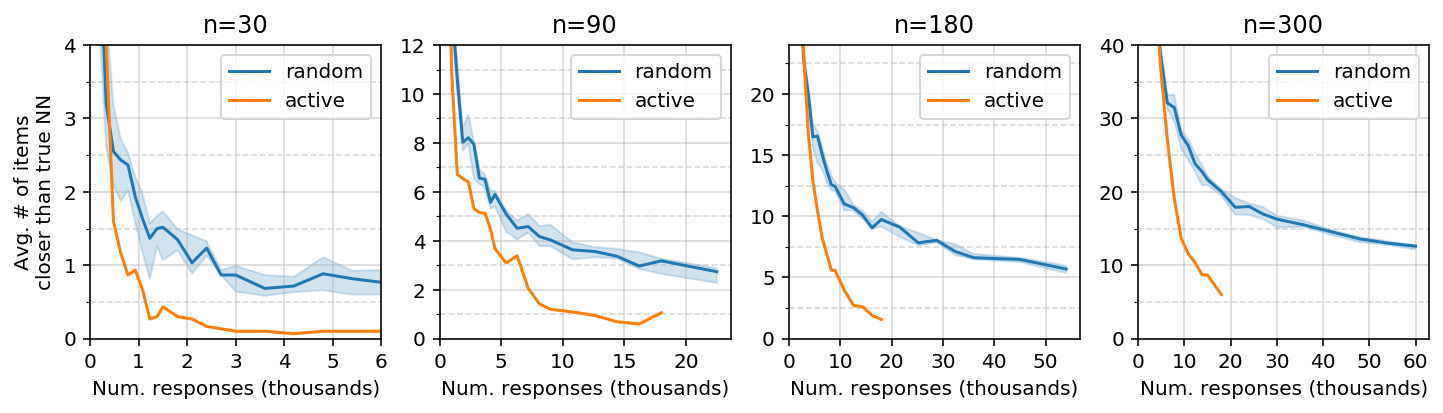

In [23]:
import altair as alt

active = (df.sampling == "active") & (df.noise_model == "CKL") 
random = (df.sampling == "random") & (df.noise_model == "CKL")
idx = (df.dataset == "simulation") & (active | random)

w = 3.0
fig, axs = plt.subplots(figsize=(4 * w, 0.9 * w), sharey=False, ncols=4, nrows=1)
kwargs = dict(
    x="num_ans", y="avg_number_closer_than_true_NN", hue="sampling", hue_order=["random", "active"], style=None,
)

frac = 40 / 300
ax = lineplot(data=df[(df.n == 30) & idx], **kwargs, ax=axs[0])
ax.set_xlim(0, 6000)
ax.set_ylim(0, frac * 30)
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.5))
ax.xaxis.set_major_locator(plt.MultipleLocator(1_000))

ax = lineplot(data=df[(df.n == 90) & idx], **kwargs, ax=axs[1])
ax.set_ylim(0, frac * 90)
ax.yaxis.set_minor_locator(plt.MultipleLocator(1))
ax.xaxis.set_major_locator(plt.MultipleLocator(5_000))
# ax.set_xlim(0, 20_000)

ax = lineplot(data=df[(df.n == 180) & idx], **kwargs, ax=axs[2])
ax.set_ylim(0, frac * 180)
ax.yaxis.set_minor_locator(plt.MultipleLocator(2.5))
ax.xaxis.set_major_locator(plt.MultipleLocator(10_000))
# ax.set_xlim(0, 20_000)

ax = lineplot(data=df[(df.n == 300) & idx], **kwargs, ax=axs[3])
ax.set_ylim(0, frac * 300)
ax.yaxis.set_minor_locator(plt.MultipleLocator(5))
ax.xaxis.set_major_locator(plt.MultipleLocator(10_000))
# ax.set_xlim(0, 20_000)

for ax in axs:
    ax.grid(alpha=0.5)
    ax.grid(alpha=0.5, linestyle="--", which="minor")
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f"{int(x / 1000)}"))
    _ = ax.set_xlabel("Num. responses (thousands)")
    _ = ax.legend(loc="best")

for ax, n in zip(axs, [30, 90, 180, 300]):
    ax.set_title(f"n={n}")
    _ = ax.set_xlim(0, None)

# axs[2].set_xlim(2_000, 5_000)
# axs[2].xaxis.set_major_locator(plt.MultipleLocator(1_000))
# axs[2].legend_.remove()

_ = axs[0].set_ylabel("Avg. # of items\ncloser than true NN")
fig.savefig("figs/N-true-NN-dist.png", bbox_inches="tight", dpi=300)

In [ ]:
from typing import Dict, Any, Union

def _get_ident(row: Union[pd.Series, Dict[str, Any]]) -> Dict[str, Any]:
    return {k: row[k] for k in ["n_train", "sampling", "noise_model", "seed", "dataset"]}

def _get_acc_ident(df, *, acc, dataset, n):
    idx = (df.dataset == dataset) & (df.n == n)
    trimmed = df[idx].copy()
    error = np.abs(trimmed["accuracy"] - acc)
    show_idx = error.idxmin()
    return _get_ident(trimmed.loc[show_idx]), trimmed.loc[show_idx, "accuracy"]

from pprint import pprint
dataset = "human"
n = 30

dataset = "simulation"
# n = 90
# for acc in [0.80, 0.815, 0.83]:

n = 180
for acc in [0.80, 0.815, 0.83]:
    ident, actual_acc = _get_acc_ident(df, acc=acc, dataset=dataset, n=n)
    ident["acc"] = acc
    ident["actual_acc"] = actual_acc
    ident["n"] = n
    ident["dataset"] = dataset
    if np.isnan(ident["seed"]):
        ident["seed"] = None
    print(ident, end=",\n")

In [ ]:
import altair as alt

active = (df.sampling == "active") & (df.noise_model == "CKL") 
random = (df.sampling == "random") & (df.noise_model == "CKL")
idx = (df.dataset == "ground_truth") & (active | random)

alt.Chart(df[idx]).mark_line(point=True).encode(
    x="num_ans",
    y=alt.Y("median(accuracy)", scale=alt.Scale(domain=(0.9, 1), clamp=True)),
    column="n",
    color=alt.Color("sampling", sort=["random", "active"]),
)

In [ ]:
import altair as alt

active = (df.sampling == "active")
# random = (df.sampling == "random")

idx = (active)
idx &= df.dataset == "ground_truth"

alt.Chart(df[idx]).mark_line(point=True).encode(
    x=alt.X("num_ans", scale=alt.Scale(domain=(0, 25_000), clamp=True)),
    y=alt.Y("accuracy", scale=alt.Scale(domain=(0.8, 1), clamp=True)),
    color="noise_model",
    column="n",
#     color=alt.Color("sampling", sort=["random", "active"]),
)

In [ ]:
import altair as alt

active = (df.sampling == "active") & (df.noise_model == "CKL")
random = (df.sampling == "random")

idx = (random | active)
# idx = df.dataset == "ground_truth"

alt.Chart(df[idx]).mark_line(point=True).encode(
    x="num_ans",
    y=alt.Y("median(accuracy)", scale=alt.Scale(domain=(0.7, 1), clamp=True)),
    row="n",
    column="dataset",
    color=alt.Color("sampling", sort=["random", "active"]),
)

In [ ]:
import altair as alt

base = df.dataset == "ground_truth"
active = (df.sampling == "active")
random = (df.sampling == "random")

idx = base & (random | active)

alt.Chart(df[idx]).mark_line(point=True).encode(
    x="num_ans",
    y=alt.Y("median(accuracy)"),#, scale=alt.Scale(domain=(0.9, 1), clamp=True)),
    column="noise_model",
    row="n",
    color=alt.Color("sampling", sort=["random", "active"]),
)